# Coursework
## Programming in Python for Business Analytics
#### Group 19

#### Exploratory Data Analysis (EDA)

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [6]:
tasks = pd.read_csv('/Users/alexander/Documents/MSc Data Science/Python/Coursework/tasks.csv')
suppliers = pd.read_csv('/Users/alexander/Documents/MSc Data Science/Python/Coursework/suppliers.csv')
cost = pd.read_csv('/Users/alexander/Documents/MSc Data Science/Python/Coursework/cost.csv.zip')
FINALdata = pd.read_csv('/Users/alexander/Documents/MSc Data Science/Python/Coursework/final_data.csv')

### 1. Worst Performing Suppliers

In [8]:
summary = cost.groupby("Supplier ID")["Cost"].agg(["mean", "var", "count"]).reset_index()
summary.head()

,Supplier ID,mean,var,count
0,S1,0.443069,0.003239,120
1,S10,0.403872,0.003431,120
2,S11,0.401271,0.002745,120
3,S12,0.415246,0.003090,120
4,S13,0.407144,0.003045,120


In [22]:
# Calculate mean, variance, and SEM
summary = cost.groupby("Supplier ID")["Cost"].agg(["mean", "var", "count"]).reset_index()
summary["std_dev"] = np.sqrt(summary["var"])
summary["sem"] = summary["std_dev"] / np.sqrt(summary["count"])

# Calculate confidence intervals (95% CI, Z = 1.96)
z = 1.96
summary["ci_lower"] = summary["mean"] - z * summary["sem"]
summary["ci_upper"] = summary["mean"] + z * summary["sem"]

# Sort by mean in descending order
summary = summary.sort_values(by="mean", ascending=False).reset_index(drop=True)

In [24]:
summary.head(10)

,Supplier ID,mean,var,count,std_dev,sem,ci_lower,ci_upper
0,S2,0.494767,0.002562,120,0.050612,0.004620,0.485712,0.503823
1,S3,0.468939,0.004160,120,0.064498,0.005888,0.457399,0.480479
2,S1,0.443069,0.003239,120,0.056911,0.005195,0.432886,0.453251
3,S26,0.441286,0.003087,120,0.055563,0.005072,0.431344,0.451227
4,S44,0.438963,0.002688,120,0.051849,0.004733,0.429686,0.448240
5,S21,0.435878,0.002741,120,0.052358,0.004780,0.426509,0.445246
6,S58,0.432525,0.002688,120,0.051844,0.004733,0.423248,0.441801
7,S61,0.431095,0.002835,120,0.053246,0.004861,0.421568,0.440622
8,S38,0.429011,0.002186,120,0.046759,0.004268,0.420645,0.437378
9,S20,0.428883,0.003264,120,0.057134,0.005216,0.418661,0.439106


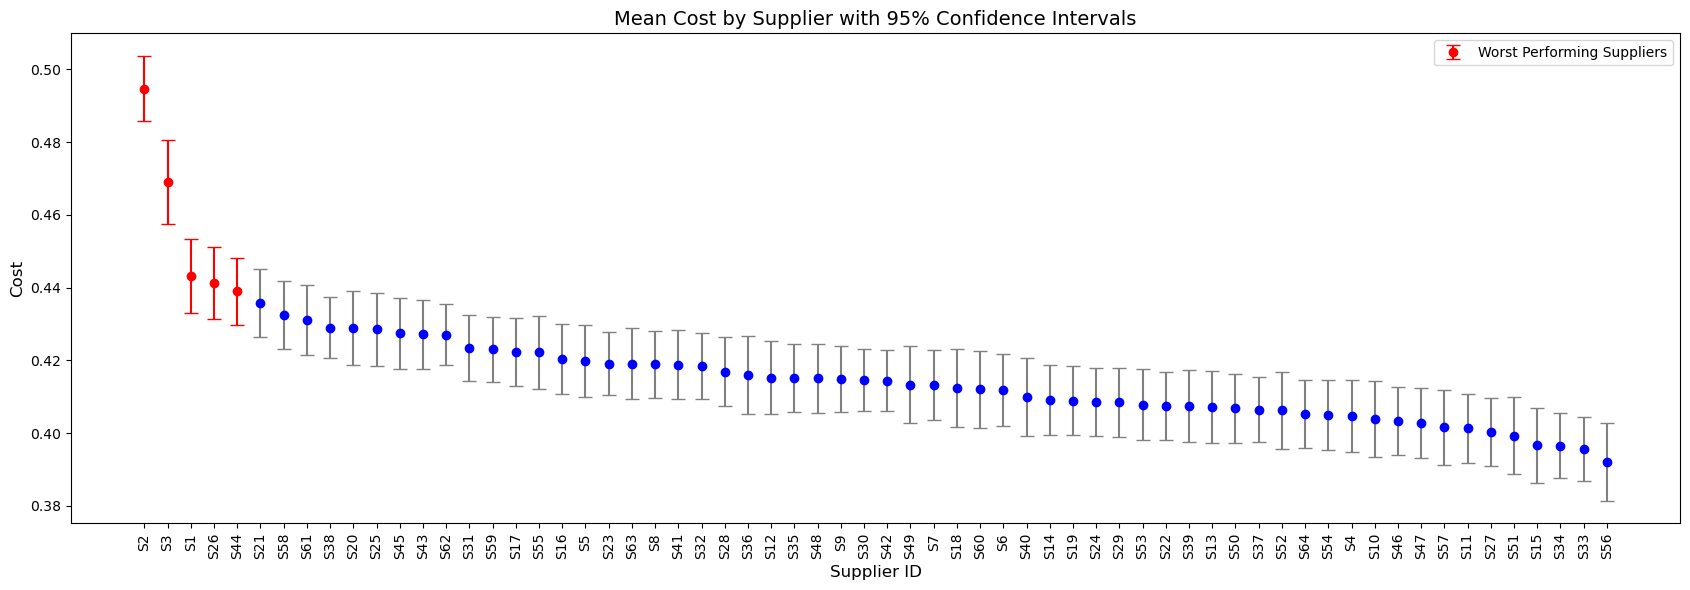

In [28]:
# Suppliers to highlight
highlight_suppliers = {"S2", "S3", "S1", "S26", "S44"}

# Define colors based on condition
colors = ["red" if supplier in highlight_suppliers else "blue" for supplier in summary["Supplier ID"]]

# Plot
plt.figure(figsize=(17, 6))
for i, supplier in enumerate(summary["Supplier ID"]):
    plt.errorbar(
        supplier,
        summary["mean"][i],
        yerr=z * summary["sem"][i],
        fmt='o',
        capsize=5,
        color=colors[i],  # Use dynamic color
        ecolor='gray' if colors[i] == "blue" else "red",  # Highlight CI in red
        label="Highlighted" if colors[i] == "red" and i == 0 else None
    )

# Rotate x-axis labels
plt.xticks(rotation=90)

# Add titles and labels
plt.title("Mean Cost by Supplier with 95% Confidence Intervals", fontsize=14)
plt.xlabel("Supplier ID", fontsize=12)
plt.ylabel("Cost", fontsize=12)
plt.legend(["Worst Performing Suppliers"], loc="upper right")

plt.tight_layout()

# Save the plot as a PNG file
plt.savefig("error_bars_highlighted.png", format="png", dpi=300)

plt.show()

In [64]:
# Calculate mean, variance, and SEM
summary2 = FINALdata.groupby("Supplier ID")["Cost"].agg(["mean", "var", "count"]).reset_index()
summary2["std_dev"] = np.sqrt(summary2["var"])
summary2["sem"] = summary2["std_dev"] / np.sqrt(summary2["count"])

# Calculate confidence intervals (95% CI, Z = 1.96)
z = 1.96
summary2["ci_lower"] = summary2["mean"] - z * summary2["sem"]
summary2["ci_upper"] = summary2["mean"] + z * summary2["sem"]

# Sort by mean in descending order
summary2 = summary2.sort_values(by="mean", ascending=False).reset_index(drop=True)

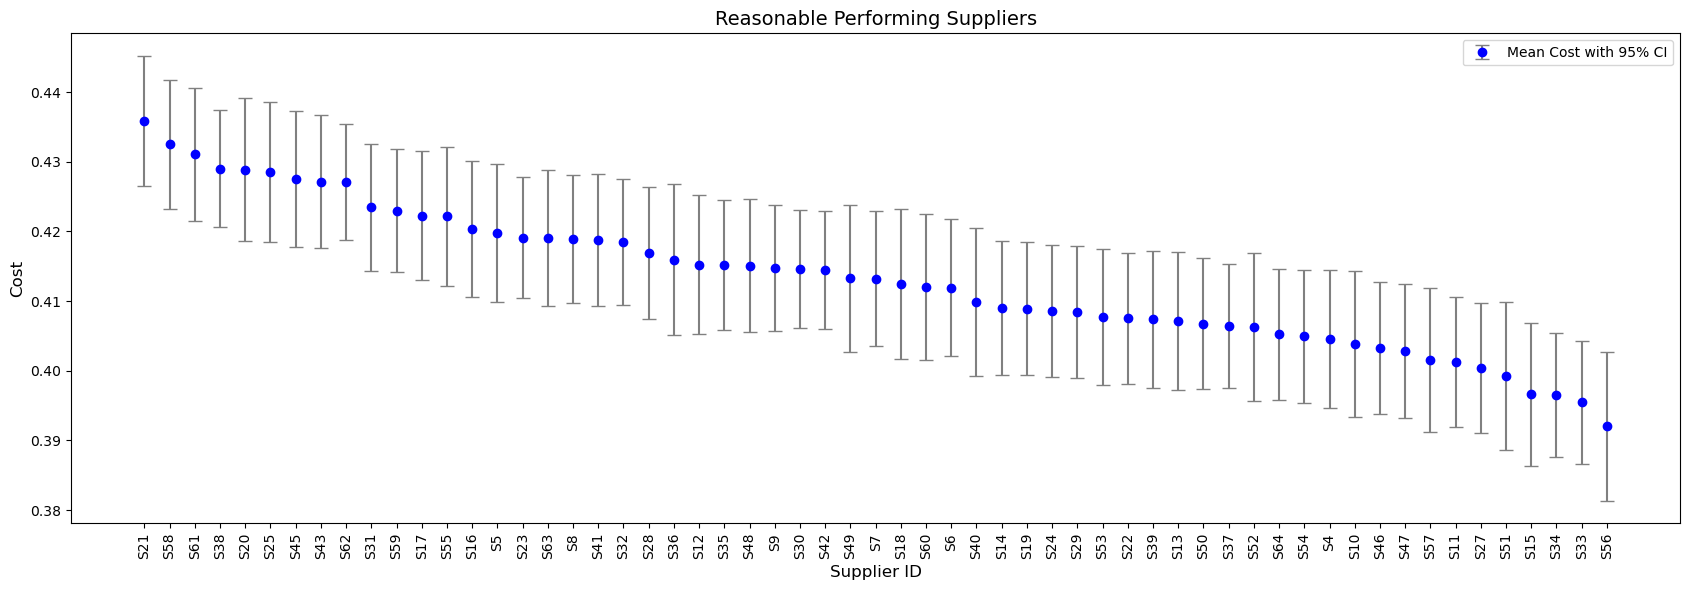

In [70]:
# Plot
plt.figure(figsize=(17, 6))
plt.errorbar(
    summary2["Supplier ID"],
    summary2["mean"],
    yerr=z * summary2["sem"],
    fmt='o',
    capsize=5,
    color='blue',
    ecolor='gray',
    label="Mean Cost with 95% CI"
)

# Rotate x-axis labels
plt.xticks(rotation=90)  # Rotate labels by 45 degrees

# Add titles and labels
plt.title("Reasonable Performing Suppliers", fontsize=14)
plt.xlabel("Supplier ID", fontsize=12)
plt.ylabel("Cost", fontsize=12)
plt.legend()

plt.tight_layout()  

# Save the plot as a PNG file
plt.savefig("error_bars_suppliers2.png", format="png", dpi=300)

plt.show()

### 2. Cluster analysis

In [30]:
# Create the Task dataset
task_columns = [col for col in FINALdata.columns if col.startswith("TF")] + ["Task ID"]
task_data = FINALdata[task_columns]

In [32]:
# Drop ID
task_features = task_data.drop(columns=["Task ID"])

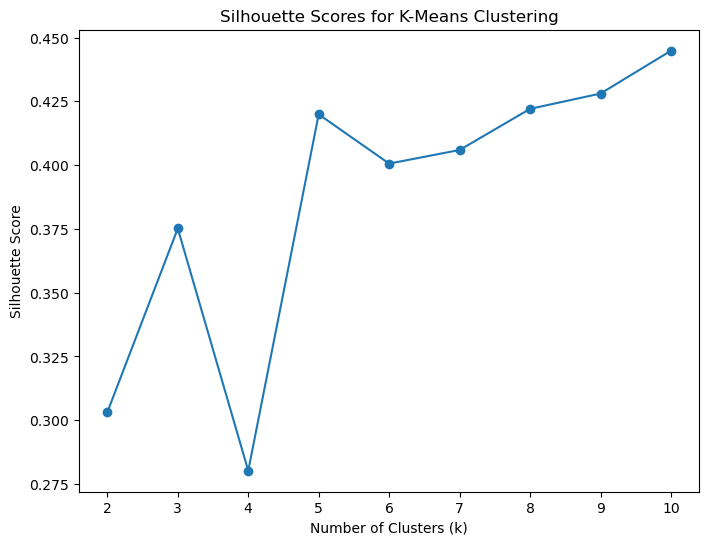

/var/folders/9q/x_qkm_295r77cyh7zn22pj3h0000gn/T/ipykernel_1972/2253780803.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  task_data["Cluster"] = clusters


In [36]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

# Determine optimal number of clusters
silhouette_scores = []
k_values = range(2, 11)
for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(task_features)
    score = silhouette_score(task_features, kmeans.labels_)
    silhouette_scores.append(score)

# Plot silhouette scores
plt.figure(figsize=(8, 6))
plt.plot(k_values, silhouette_scores, marker='o')
plt.title("Silhouette Scores for K-Means Clustering")
plt.xlabel("Number of Clusters (k)")
plt.ylabel("Silhouette Score")
plt.show()

# Fit K-Means with the optimal number of clusters
optimal_k = k_values[silhouette_scores.index(max(silhouette_scores))]
kmeans = KMeans(n_clusters=optimal_k, random_state=42)
clusters = kmeans.fit_predict(task_features)

# Add cluster labels to the original data
task_data["Cluster"] = clusters


In [38]:
from sklearn.cluster import KMeans

# Fit K-Means with the optimal number of clusters
optimal_k = 5
kmeans = KMeans(n_clusters=optimal_k, random_state=42)
clusters = kmeans.fit_predict(task_features)

# Add the cluster labels to the original dataset
task_data["Cluster"] = clusters

# Inspect the first few rows
print(task_data.head())


      TF71       TF3      TF87       TF5      TF52      TF64      TF59  \
0  0.03876  0.648543 -0.282124  0.074792 -0.596797  0.185185  0.148936   
1  0.03876  0.648543 -0.282124  0.074792 -0.596797  0.185185  0.148936   
2  0.03876  0.648543 -0.282124  0.074792 -0.596797  0.185185  0.148936   
3  0.03876  0.648543 -0.282124  0.074792 -0.596797  0.185185  0.148936   
4  0.03876  0.648543 -0.282124  0.074792 -0.596797  0.185185  0.148936   

       TF13      TF25      TF50  ...      TF27      TF38      TF18      TF37  \
0  0.735664  0.718965  0.534884  ... -0.476023  0.142857 -0.540603  0.544917   
1  0.735664  0.718965  0.534884  ... -0.476023  0.142857 -0.540603  0.544917   
2  0.735664  0.718965  0.534884  ... -0.476023  0.142857 -0.540603  0.544917   
3  0.735664  0.718965  0.534884  ... -0.476023  0.142857 -0.540603  0.544917   
4  0.735664  0.718965  0.534884  ... -0.476023  0.142857 -0.540603  0.544917   

       TF77  TF11     TF105      TF36  Task ID  Cluster  
0 -0.179328  -0.

/var/folders/9q/x_qkm_295r77cyh7zn22pj3h0000gn/T/ipykernel_1972/1436976816.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  task_data["Cluster"] = clusters


In [42]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# Reduce to 2 dimensions for visualization
pca = PCA(n_components=2)
task_pca = pca.fit_transform(task_features)

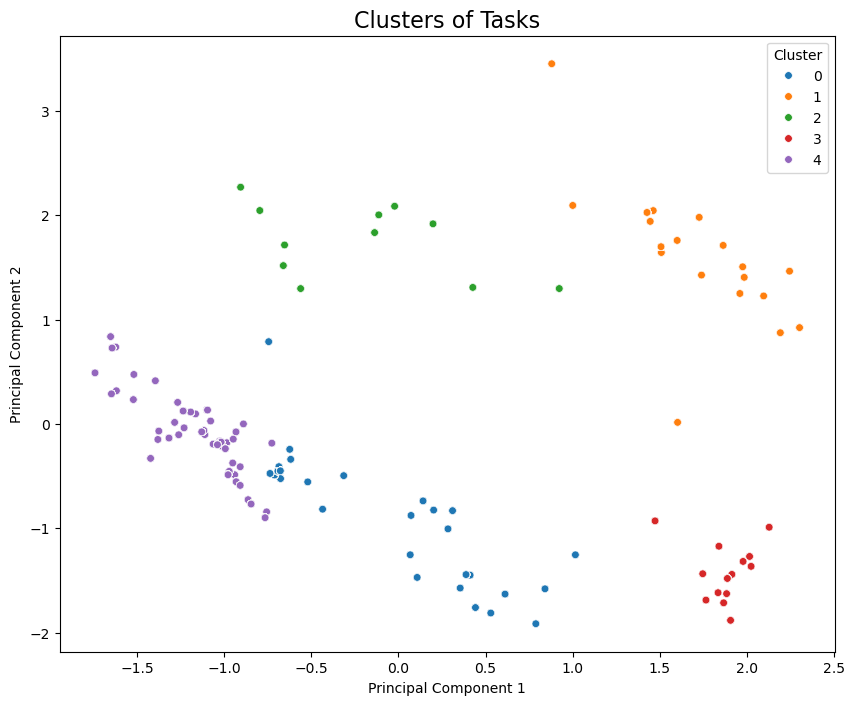

In [60]:
import matplotlib.pyplot as plt
import seaborn as sns

# Scatter plot of clusters
plt.figure(figsize=(10, 8))
sns.scatterplot(
    x=task_pca[:, 0],
    y=task_pca[:, 1],
    hue=clusters,
    palette="tab10",
    s=30
)
plt.title("Clusters of Tasks", fontsize=16)
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.legend(title="Cluster")

# Save the plot as a PNG file
plt.savefig("cluster_tasks.png", format="png", dpi=300)

plt.show()


In [46]:
# Add the Cost column back to the supplier dataset
task_data.loc[:, "Cost"] = FINALdata["Cost"]

/var/folders/9q/x_qkm_295r77cyh7zn22pj3h0000gn/T/ipykernel_1972/2649843944.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  task_data.loc[:, "Cost"] = FINALdata["Cost"]


In [48]:
# Display unique categories in the StateHoliday column
task_data['Cluster'].unique()

array([1, 2, 3, 0, 4], dtype=int32)

In [50]:
# Calculate mean, variance, and SEM
summary_cluster = task_data.groupby("Cluster")["Cost"].agg(["mean", "var", "count"]).reset_index()
summary_cluster["std_dev"] = np.sqrt(summary_cluster["var"])
summary_cluster["sem"] = summary_cluster["std_dev"] / np.sqrt(summary_cluster["count"])

# Calculate confidence intervals (95% CI, Z = 1.96)
summary_cluster["ci_lower"] = summary_cluster["mean"] - z * summary_cluster["sem"]
summary_cluster["ci_upper"] = summary_cluster["mean"] + z * summary_cluster["sem"]

# Sort by mean in descending order
summary_cluster = summary_cluster.sort_values(by="mean", ascending=False)

In [52]:
summary_cluster["Cluster"] = summary_cluster["Cluster"].astype("category")

In [54]:
summary_cluster.head()

,Cluster,mean,var,count,std_dev,sem,ci_lower,ci_upper
2,2,0.458956,0.001759,649,0.041943,0.001646,0.455729,0.462183
4,4,0.438622,0.001107,2832,0.033277,0.000625,0.437396,0.439847
0,0,0.418836,0.002997,1652,0.054744,0.001347,0.416196,0.421476
1,1,0.364663,0.001588,1121,0.039851,0.001190,0.362330,0.366996
3,3,0.344888,0.000416,826,0.020399,0.000710,0.343496,0.346279


In [56]:
task_data["Cluster"] = task_data["Cluster"].astype("category")

/var/folders/9q/x_qkm_295r77cyh7zn22pj3h0000gn/T/ipykernel_1972/2155284744.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  task_data["Cluster"] = task_data["Cluster"].astype("category")


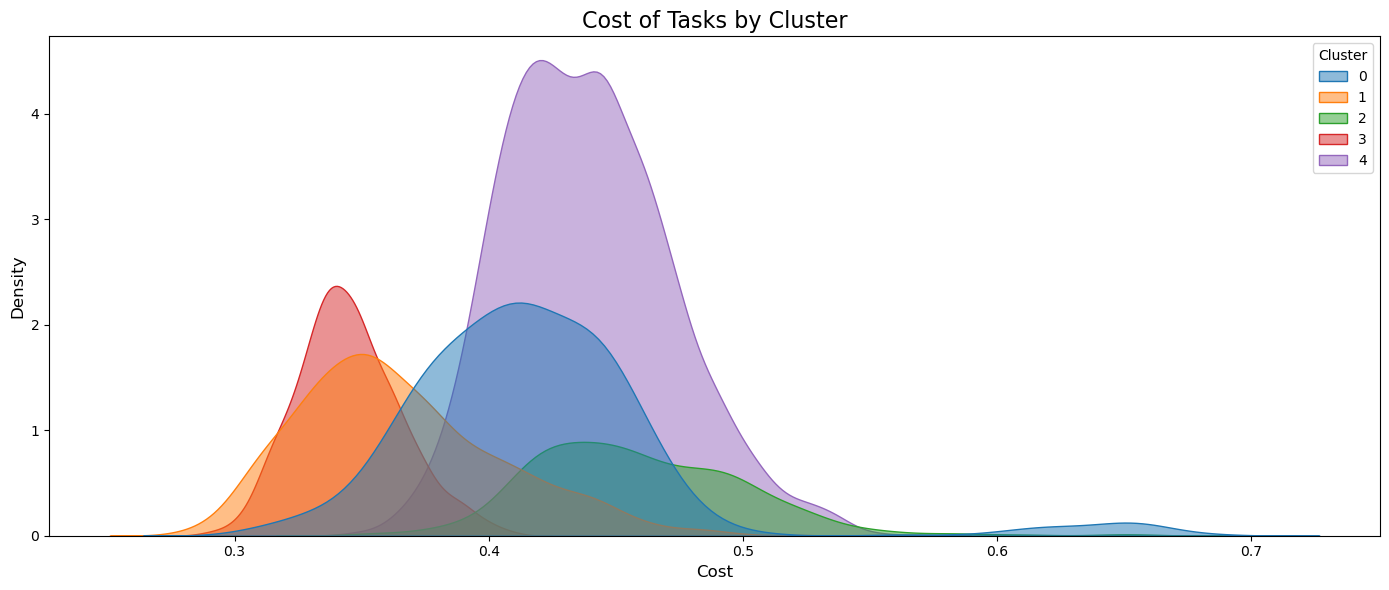

In [58]:
plt.figure(figsize=(14, 6))

# Use Seaborn's kdeplot to plot densities for each cluster
sns.kdeplot(
    data=task_data,
    x="Cost",
    hue="Cluster",
    fill=True,  # Optional: adds shading under the curves
    alpha=0.5    # Transparency for better overlap visualization
)

plt.title("Cost of Tasks by Cluster", fontsize=16)
plt.xlabel("Cost", fontsize=12)
plt.ylabel("Density", fontsize=12)

plt.tight_layout()

plt.savefig("cost_cluster.png", format="png", dpi=300)

plt.show()